# Data plan:

1. Initial data exploration

2. EDA 

3. Initial model: compare models & optimise Hp

4. Final model deployment on test data. 

### Import packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

warnings.simplefilter(action = 'ignore', category = FutureWarning)
pd.set_option('display.max_columns', None)

## `Initial data exploration`

In [2]:
df = pd.read_csv("../input/widsdatathon2022/train.csv")
#df_test = pd.read_csv("../input/widsdatathon2022/test.csv")

print('No columns: ', len(df.columns))
# print()
# df.info()

No columns:  64


----------------------
### Types of features:

`Outcome` feature: 
- `site_eui` : Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills

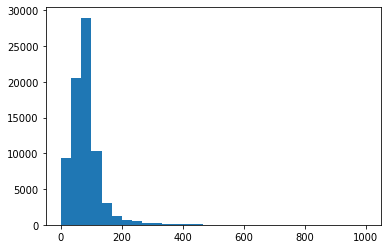

In [3]:
# print(df['site_eui'].describe())
plt.hist(df['site_eui'], bins = 30)
plt.show()

In [4]:
cols_dict = {}

for typ in ('object','float64', 'int64'):
    cols = df.select_dtypes(typ).columns
    cols_dict[typ] = cols.tolist()
    print ('{}: {}'.format(typ, len(cols)))
    print(cols.tolist())
    print()

object: 3
['State_Factor', 'building_class', 'facility_type']

float64: 24
['floor_area', 'year_built', 'energy_star_rating', 'ELEVATION', 'january_avg_temp', 'february_avg_temp', 'march_avg_temp', 'april_avg_temp', 'may_avg_temp', 'june_avg_temp', 'july_avg_temp', 'august_avg_temp', 'september_avg_temp', 'october_avg_temp', 'november_avg_temp', 'december_avg_temp', 'precipitation_inches', 'snowfall_inches', 'avg_temp', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog', 'site_eui']

int64: 37
['Year_Factor', 'january_min_temp', 'january_max_temp', 'february_min_temp', 'february_max_temp', 'march_min_temp', 'march_max_temp', 'april_min_temp', 'april_max_temp', 'may_min_temp', 'may_max_temp', 'june_min_temp', 'june_max_temp', 'july_min_temp', 'july_max_temp', 'august_min_temp', 'august_max_temp', 'september_min_temp', 'september_max_temp', 'october_min_temp', 'october_max_temp', 'november_min_temp', 'november_max_temp', 'december_min_temp', 'decem

In [5]:
for col in cols_dict['object']:
    print(col, ": ", df[col].value_counts().shape[0])
    print(df[col].value_counts())
    print()

State_Factor :  7
State_6     50840
State_11     6412
State_1      5618
State_2      4871
State_4      4300
State_8      3701
State_10       15
Name: State_Factor, dtype: int64

building_class :  2
Residential    43558
Commercial     32199
Name: building_class, dtype: int64

facility_type :  60
Multifamily_Uncategorized                    39455
Office_Uncategorized                         12512
Education_Other_classroom                     3860
Lodging_Hotel                                 2098
2to4_Unit_Building                            1893
Commercial_Other                              1744
5plus_Unit_Building                           1273
Warehouse_Nonrefrigerated                     1255
Retail_Uncategorized                          1130
Education_College_or_university               1056
Nursing_Home                                   772
Education_Uncategorized                        709
Mixed_Use_Commercial_and_Residential           672
Lodging_Dormitory_or_fraternity_sorority 

In [6]:
for col in cols_dict['float64'][:3]:
    print(col)
    print(df[col].describe()[['mean','50%','25%','75%']])
    print()

floor_area
mean    165983.865858
50%      91367.000000
25%      62379.000000
75%     166000.000000
Name: floor_area, dtype: float64

year_built
mean    1952.306764
50%     1951.000000
25%     1927.000000
75%     1977.000000
Name: year_built, dtype: float64

energy_star_rating
mean    61.048605
50%     67.000000
25%     40.000000
75%     85.000000
Name: energy_star_rating, dtype: float64



----------
## `Exploratory Data Analysis`:

### Examine `Temperature measures`:

#### Average measures:
- `_min_temp`, `_avg_temp`, `_max_temp` + 1 `avg_temp`
- 3 x 12 + 1

In [7]:
dict_temp = {}
dict_temp['tempetature'] = df.columns[[c.endswith('temp') for c in df.columns]].tolist()

temp_cols = df.columns[[c.endswith('temp') for c in df.columns]].tolist()
df.columns[[c.endswith('temp') for c in df.columns]] #.tolist()

Index(['january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'avg_temp'],
      dtype='object')

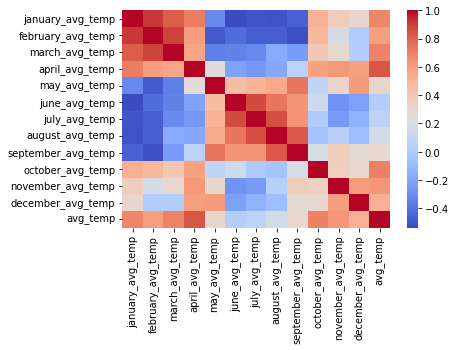

In [8]:
temp_corr = df[df.columns[[c.endswith('avg_temp') for c in df.columns]].tolist()].corr()
sns.heatmap(temp_corr, cmap="coolwarm")
plt.show()

In [9]:
temp_min = df[df.columns[[el.endswith('min_temp') for el in df.columns]]].describe().T
temp_min['month'] = temp_min.index
temp_min['month'] = [m.replace('_min_temp','') for m in temp_min.index]

temp_max = df[df.columns[[el.endswith('max_temp') for el in df.columns]]].describe().T
temp_max['month'] = temp_max.index
temp_max['month'] = [m.replace('_max_temp','') for m in temp_max.index]

temp_avg = df[df.columns[[el.endswith('_avg_temp') for el in df.columns]]].describe().T
temp_avg['month'] = temp_avg.index
temp_avg['month'] = [m.replace('_avg_temp','') for m in temp_avg.index]

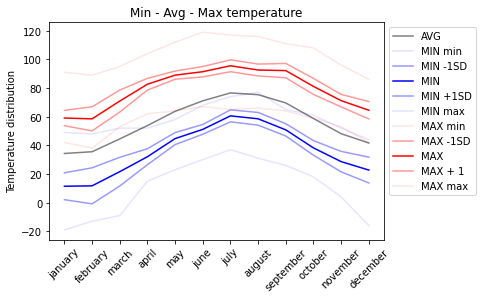

In [10]:
plt.plot(temp_avg['month'], temp_avg['mean'], label = 'AVG', color = 'grey')

plt.plot(temp_min['month'], temp_min['min'], label = 'MIN min', color = 'blue', alpha = 0.1)
plt.plot(temp_min['month'], (temp_min['mean'] - temp_min['std']), label = 'MIN -1SD', 
         color = 'blue', alpha = 0.4)
plt.plot(temp_min['month'], temp_min['mean'], label = 'MIN', color = 'blue')
plt.plot(temp_min['month'], (temp_min['mean'] + temp_min['std']), label = 'MIN +1SD', 
         color = 'blue', alpha = 0.4)
plt.plot(temp_min['month'], temp_min['max'], label = 'MIN max', color = 'blue', alpha = 0.1)

plt.plot(temp_max['month'], temp_max['min'], label = 'MAX min', color = 'red', alpha = 0.1)
plt.plot(temp_max['month'], (temp_max['mean'] - temp_max['std']), label = 'MAX -1SD', 
         color = 'red', alpha = 0.4)
plt.plot(temp_max['month'], temp_max['mean'], label = 'MAX', color = 'red')
plt.plot(temp_max['month'], (temp_max['mean'] + temp_max['std']), label = 'MAX + 1', 
         color = 'red', alpha = 0.4)
plt.plot(temp_max['month'], temp_max['max'], label = 'MAX max', color = 'red', alpha = 0.1)

plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Min - Avg - Max temperature')
plt.ylabel('Temperature distribution')
plt.show()

#### Extreme temperatures:

- `days_below_*` and `days_above_*`

In [11]:
below = df.columns[[c.startswith('days_below') for c in df.columns]]
above = df.columns[[c.startswith('days_above') for c in df.columns]]
extreme = df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]]

dict_temp['extreme'] = df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]].to_list()

df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]]

Index(['days_below_30F', 'days_below_20F', 'days_below_10F', 'days_below_0F',
       'days_above_80F', 'days_above_90F', 'days_above_100F',
       'days_above_110F'],
      dtype='object')

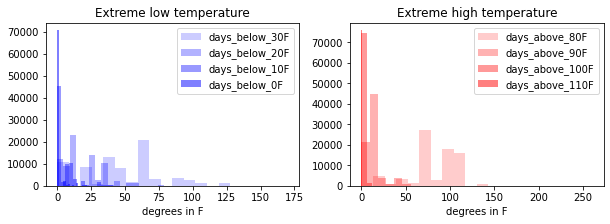

In [12]:
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
for alpha, b in zip([0.2,0.3,0.4,0.5], below):
    plt.hist(df[b], color = 'blue', alpha = alpha, bins = 20, label = b)
    plt.legend()
    plt.title('Extreme low temperature')
    plt.xlabel('degrees in F')
    
plt.subplot(1,2,2)
for alpha, a in zip([0.2,0.3,0.4,0.5], above):
    plt.hist(df[a], color = 'red', alpha = alpha, bins = 20, label = a)
    plt.legend()
    plt.title('Extreme high temperature')
    plt.xlabel('degrees in F')

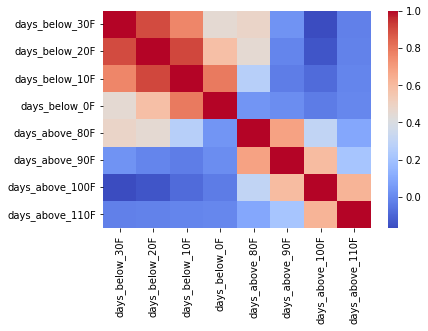

In [13]:
extr_corr = df[df.columns[[c.startswith(('days_below','days_above')) for c in df.columns]].tolist()].corr()
sns.heatmap(extr_corr, cmap="coolwarm")
plt.show()

In [14]:
df.drop(temp_cols, axis = 1).columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'cooling_degree_days', 'heating_degree_days', 'precipitation_inches',
       'snowfall_inches', 'snowdepth_inches', 'days_below_30F',
       'days_below_20F', 'days_below_10F', 'days_below_0F', 'days_above_80F',
       'days_above_90F', 'days_above_100F', 'days_above_110F',
       'direction_max_wind_speed', 'direction_peak_wind_speed',
       'max_wind_speed', 'days_with_fog', 'site_eui', 'id'],
      dtype='object')

In [15]:
df.drop(temp_cols, axis = 1).head(n = 3)

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,115,2960,16.59,0.0,0,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2


-----------------
### Missing data:

<AxesSubplot:>

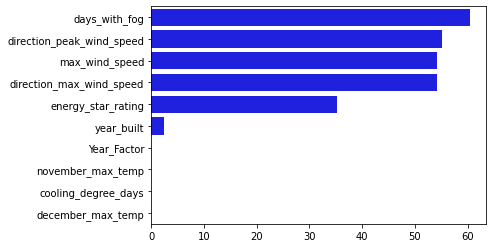

In [16]:
missing_data = np.round((df.isnull().sum() / df.shape[0]) * 100, 2).sort_values(ascending = False)[:10]

sns.barplot(missing_data.values, missing_data.index, color = 'b')